# FRDiff tutorial

이 주피터 노트북은 "FRDiff : Feature Reuse for Universal Training-free Acceleration of Diffusion Models [ECCV24]" 를 기반으로, Diffusion Caching기술에 대한 상세한 이해와 구현을 목표로 합니다.

순서는 다음과 같습니다.
- Diffusion Model의 Temporarl Redundancy 분석.
- Feature Reuse의 구현
- Score Mixing의 구현.
- 성능 비교

## Install Dependancies

In [1]:
!pip install diffusers transformers accelerate

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.8/789.8 kB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 MB 82.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 92.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 1

## Standard Inference

우선 아무 경량화 기술을 적용하지 않은 일반적인 Diffusion Model의 inference를 진행합니다.

이 예시에서, 모델은 SDXL(Stable Diffusion XL)을 사용하고, Solver로는 DDIM 을 사용합니다. 

In [ ]:
import torch

from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import StableDiffusionXLPipeline
from diffusers import StableDiffusionPipeline, DDIMScheduler

# Stable Diffusion 1.4
# pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16)

# SDXL
pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                                 variant="fp16", torch_dtype=torch.float16,
                                                 use_safetensors=True)

pipe.to(f'cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

50 step Denoising 으로 설정하고, prompt를 설정합니다. 

In [ ]:
seed = 0

# Sampling Step
num_steps = 50

# Set your prompt !
prompt = "a photo of an astronaut riding a horse on mars, trending on artstation, high quality, detailed, cinematic lighting"

### DDIM Sampling

In [ ]:
import time

generator = torch.Generator().manual_seed(seed)

t1 = time.time()
image_ddim = pipe(prompt, generator=generator, num_inference_steps=num_steps).images[0]
t2 = time.time()

time_ddim = t2 - t1
print(f"DDIM Sampling Time: {time_ddim:.2f} seconds")
image_ddim

이미지가 정상적으로 생성되는 것을 확인할 수 있습니다.

### Temporal Redundancy Analysis

SDXL은 Unet모델을 사용하며, 이는 주로 두가지 종류의 블록으로 구성되어 있습니다.

- ResnetBlock2D
- Transformer2DModel

In [ ]:
import torch

import numpy as np
from typing import Union, Optional, Dict, Callable, List, Any, Tuple

from diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl import (
    StableDiffusionXLPipeline,
    StableDiffusionXLPipelineOutput,
    retrieve_timesteps,
    rescale_noise_cfg,
    XLA_AVAILABLE,
)
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import (
    StableDiffusionPipeline, StableDiffusionPipelineOutput
)

from diffusers.models.resnet import ResnetBlock2D
from diffusers.models.upsampling import Upsample2D
from diffusers.models.downsampling import Downsample2D
from diffusers.models.transformers.transformer_2d import Transformer2DModel, Transformer2DModelOutput
from diffusers.utils import is_torch_version, USE_PEFT_BACKEND, deprecate

In [ ]:
for n , m in pipe.unet.named_modules():
    if isinstance(m, ResnetBlock2D):
        print(m.__class__.__name__, n)
    elif isinstance(m, Transformer2DModel):
        print(m.__class__.__name__, n)

위에서 볼 수 있듯, ResBlock과 TransformerBlock 이 번갈아가며 나타나는 구조임을 알 수 있습니다.

Temporal Redundancy를 분석하기 위해, 우선은 ResBlock에 대해서만 분석하도록 하겠습니다.

### ResnetBlock2D

아래는 SDXL의 ResBlock의 forward path에 대한 *원본 구현*입니다. 

원본 코드 'https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/resnet.py' 에서도 확인할 수 있습니다.

In [ ]:
def forward(self, input_tensor: torch.Tensor, temb: torch.Tensor, *args, **kwargs) -> torch.Tensor:
    if len(args) > 0 or kwargs.get("scale", None) is not None:
        deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
        deprecate("scale", "1.0.0", deprecation_message)

    hidden_states = input_tensor

    hidden_states = self.norm1(hidden_states)
    hidden_states = self.nonlinearity(hidden_states)

    if self.upsample is not None:
        # upsample_nearest_nhwc fails with large batch sizes. see https://github.com/huggingface/diffusers/issues/984
        if hidden_states.shape[0] >= 64:
            input_tensor = input_tensor.contiguous()
            hidden_states = hidden_states.contiguous()
        input_tensor = self.upsample(input_tensor)
        hidden_states = self.upsample(hidden_states)
    elif self.downsample is not None:
        input_tensor = self.downsample(input_tensor)
        hidden_states = self.downsample(hidden_states)

    hidden_states = self.conv1(hidden_states)

    if self.time_emb_proj is not None:
        if not self.skip_time_act:
            temb = self.nonlinearity(temb)
        temb = self.time_emb_proj(temb)[:, :, None, None]

    if self.time_embedding_norm == "default":
        if temb is not None:
            hidden_states = hidden_states + temb
        hidden_states = self.norm2(hidden_states)
    elif self.time_embedding_norm == "scale_shift":
        if temb is None:
            raise ValueError(
                f" `temb` should not be None when `time_embedding_norm` is {self.time_embedding_norm}"
            )
        time_scale, time_shift = torch.chunk(temb, 2, dim=1)
        hidden_states = self.norm2(hidden_states)
        hidden_states = hidden_states * (1 + time_scale) + time_shift
    else:
        hidden_states = self.norm2(hidden_states)

    hidden_states = self.nonlinearity(hidden_states)

    hidden_states = self.dropout(hidden_states)
    hidden_states = self.conv2(hidden_states)

    if self.conv_shortcut is not None:
        input_tensor = self.conv_shortcut(input_tensor.contiguous())

    output_tensor = (input_tensor + hidden_states) / self.output_scale_factor

    return output_tensor

코드에서 확인할 수 있듯, 다음과 같은 연산 구조로 이루어져 있음을 알 수 있습니다.

1. res <- x
2. x <- Conv1(x)
3. x <- Conv2 ( NonLinear( x+ t ) )
4. x <- res + x

Temporal Redundancy 분석을 위한 Logging code를 삽입해보도록 하겠습니다.

\#\#\#\# MODIFED \#\#\#\# 로 감싸진 부분이 수정된 부분입니다.

In [ ]:
# Retrieved from Original repo : 'https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/resnet.py
class SkipResnetBlock2D(ResnetBlock2D):

    def forward(self, input_tensor: torch.Tensor, temb: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        hidden_states = input_tensor

        hidden_states = self.norm1(hidden_states)
        hidden_states = self.nonlinearity(hidden_states)

        if self.upsample is not None:
            # upsample_nearest_nhwc fails with large batch sizes. see https://github.com/huggingface/diffusers/issues/984
            if hidden_states.shape[0] >= 64:
                input_tensor = input_tensor.contiguous()
                hidden_states = hidden_states.contiguous()
            input_tensor = self.upsample(input_tensor)
            hidden_states = self.upsample(hidden_states)
        elif self.downsample is not None:
            input_tensor = self.downsample(input_tensor)
            hidden_states = self.downsample(hidden_states)


        #######################################
        ############## MODIFIED ###############
        self.res_memory.append(hidden_states.cpu())
        ############## MODIFIED ###############
        #######################################


        hidden_states = self.conv1(hidden_states)

        if self.time_emb_proj is not None:
            if not self.skip_time_act:
                temb = self.nonlinearity(temb)
            temb = self.time_emb_proj(temb)[:, :, None, None]

        if self.time_embedding_norm == "default":
            if temb is not None:
                hidden_states = hidden_states + temb
            hidden_states = self.norm2(hidden_states)
        elif self.time_embedding_norm == "scale_shift":
            if temb is None:
                raise ValueError(
                    f" `temb` should not be None when `time_embedding_norm` is {self.time_embedding_norm}"
                )
            time_scale, time_shift = torch.chunk(temb, 2, dim=1)
            hidden_states = self.norm2(hidden_states)
            hidden_states = hidden_states * (1 + time_scale) + time_shift
        else:
            hidden_states = self.norm2(hidden_states)

        hidden_states = self.nonlinearity(hidden_states)

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.conv2(hidden_states)

        if self.conv_shortcut is not None:
            input_tensor = self.conv_shortcut(input_tensor.contiguous())

        output_tensor = (input_tensor + hidden_states) / self.output_scale_factor

        return output_tensor

Logging code를 삽입할 레이어를 선택하고, `ResnetBlock2D` 클래스를, 상속한 `SkipResnetBlock2D`로 클래스를 바꿔 logging code를 injection합니다.

In [ ]:
target_layers = ['down_blocks.0.resnets.0','mid_block.resnets.0']

# Patch Classes
for n, m in pipe.unet.named_modules() :
    #print(n)
    if n in target_layers:
        #print(n)
        print(f'Convert {type(m)} to SkipResnetBlock2D')
        m.__class__ = SkipResnetBlock2D
        m.res_memory = [] 

이미지를 생성하여 로그를 가져옵니다.

In [ ]:
%%time

generator = torch.Generator().manual_seed(seed)
pipe(prompt, generator=generator, num_inference_steps=num_steps).images[0]

In [ ]:
logs = []

for n,m in pipe.unet.named_modules():
    if isinstance(m, SkipResnetBlock2D):
        print(f'Collecting {n} logs')
        logs.append(m.res_memory)

이제 가져온 로그로, Temporal Redundancy를 분석합니다.

우선, 각 타임스텝마다 저장한 feature tensor를 한 채널에 대해 Visualize함으로써, 시간에 따른 feature의 변화를 시각화합니다.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

log = logs[0]
channel_num = 1

num_features = len(log)
cols = 10
rows = (num_features + cols - 1) // cols  # 올림

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))

for idx, t_feature in enumerate(log):
    r = idx // cols
    c = idx % cols
    t_img = t_feature[0][channel_num].cpu().numpy()
    axes[r, c].imshow(t_img, cmap='gray')
    axes[r, c].axis('off')
    axes[r, c].set_title(f"t={idx}")

# 남는 subplot은 안보이게
for idx in range(num_features, rows * cols):
    r = idx // cols
    c = idx % cols
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()

위에서 확인할 수 있듯, 이러한 featuer들은 연속된 시간변화에 대해 매우 작은 변화량만을 가집니다.

아래와 같이 이를 수치적으로도 분석할 수 있습니다. 

In [ ]:
plt.figure(figsize=(10, 5))
for layer_log in logs :
    errs = []
    for t in range(1, len(layer_log)):
        err = (layer_log[t] - layer_log[t-1]).abs().mean().item()
        errs.append(err)

    
    plt.plot(errs)
plt.xlabel("Time Step")
plt.ylabel("Mean Absolute Error")
plt.title("Temporal Feature Differences")

마찬가지로 작은 수치적 에러를 가짐을 확인할 수 있습니다. 이러한 작은 변화량은, 한번 계산한 피쳐를 다음 스텝에 재사용함으로써 계산량을 크게 줄일 수 있는 가능성을 시사합니다.

## FRDiff

이제 저희 연구인 FRDiff의 구현을 다뤄볼 것입니다. FRDiff는 총 세가지 컴포넌트인
- Feature Reuse
- Score Mixing
- Auto-FR

로 진행되지만, 이 튜토리얼에서는 Feature-Reuse와 Score-Mixing에 대해서만 구현해보도록 하겠습니다.

### 1. Feature-Reuse

Feature Reuse는 다음과 같은 formulation을 가집니다.

우선, `ResBlock`이나 `TransformerBlock` 같은 Residual 구조를 가지는 모든 블록 $ y \leftarrow x + \mathcal{F}(x,t)$ 들의 non residual $\mathcal{F}(x,t)$ 부분을, 다음과 같은 형태로 decompose합니다.

$\mathcal{F}(x_t,t) \leftarrow f( \mathcal{S}(x_t), t)$

이때 $\mathcal{S}(x_t)$ 는 time step 에 대한 정보를 계산하지 않는 부분으로, *Spatial Block*이라고 지칭합니다.

예를 들어, 이전 ResBLock구조였던

1. res <- x
2. x <- Conv1(x)
3. x <- Conv2 ( NonLinear( x+ t ) )
4. x <- res + x

에서는, 2. x <- Conv1(x) 부분이 *Spatial Block*에 해당합니다. 

---

다음으로, Feature Caching을 수행할 지점인 *Keyframe set*  $\mathcal{K}$ (i.e, {10,20,30,40,50} )을 정의하고, 

현재 denosing step $t$가, $t \in \mathcal{K}$ 일때, Caching 을 진행합니다.  
$if\ \  t \in \mathcal{K} :$  
$\quad M \leftarrow S(x_t)$  
$y \leftarrow f(M, t) + x_t$

---

아래는 이에 따른 ResBlock에서의 구현입니다. \#\#\#\# MODIFED \#\#\#\# 로 감싸진 부분이 수정된 부분입니다.

In [ ]:

# Retrieved from Original repo : 'https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/resnet.py
class SkipResnetBlock2D(ResnetBlock2D):
    
    ### MODIFIED #####
    # cleaner
    def update(self):
        self.layer_memory = None

    def forward(self, input_tensor: torch.Tensor, temb: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        if len(args) > 0 or kwargs.get("scale", None) is not None:
            deprecation_message = "The `scale` argument is deprecated and will be ignored. Please remove it, as passing it will raise an error in the future. `scale` should directly be passed while calling the underlying pipeline component i.e., via `cross_attention_kwargs`."
            deprecate("scale", "1.0.0", deprecation_message)

        hidden_states = input_tensor

        hidden_states = self.norm1(hidden_states)
        hidden_states = self.nonlinearity(hidden_states)

        if self.upsample is not None:
            # upsample_nearest_nhwc fails with large batch sizes. see https://github.com/huggingface/diffusers/issues/984
            if hidden_states.shape[0] >= 64:
                input_tensor = input_tensor.contiguous()
                hidden_states = hidden_states.contiguous()
            input_tensor = self.upsample(input_tensor)
            hidden_states = self.upsample(hidden_states)
        elif self.downsample is not None:
            input_tensor = self.downsample(input_tensor)
            hidden_states = self.downsample(hidden_states)


        #######################################
        ############## MODIFIED ###############
        # Original Forward
        # hidden_states = self.conv1(hidden_states)

        # Our Feature Reuse
        if self.GLOBAL_BUFFER.current_step in self.GLOBAL_BUFFER.skip_cnt: # if t \in K
            self.layer_memory = self.conv1(hidden_states)
        hidden_states = self.layer_memory
        ############## MODIFIED ###############
        #######################################


        if self.time_emb_proj is not None:
            if not self.skip_time_act:
                temb = self.nonlinearity(temb)
            temb = self.time_emb_proj(temb)[:, :, None, None]

        if self.time_embedding_norm == "default":
            if temb is not None:
                hidden_states = hidden_states + temb
            hidden_states = self.norm2(hidden_states)
        elif self.time_embedding_norm == "scale_shift":
            if temb is None:
                raise ValueError(
                    f" `temb` should not be None when `time_embedding_norm` is {self.time_embedding_norm}"
                )
            time_scale, time_shift = torch.chunk(temb, 2, dim=1)
            hidden_states = self.norm2(hidden_states)
            hidden_states = hidden_states * (1 + time_scale) + time_shift
        else:
            hidden_states = self.norm2(hidden_states)

        hidden_states = self.nonlinearity(hidden_states)

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.conv2(hidden_states)

        if self.conv_shortcut is not None:
            input_tensor = self.conv_shortcut(input_tensor.contiguous())

        output_tensor = (input_tensor + hidden_states) / self.output_scale_factor

        return output_tensor

다음은 Transformer2D Block에서의 구현입니다.
Transformerblock은 블록 전체가 인풋으로 timestep정보를 사용하지 않기 때문에, 단순히 residual 파트만 분리하여 reuse할 수 있습니다. 

따라서 다음과 같이 구조로 구현됩니다. (_forward는 기존 forward function.)

```

    def forward(
        self,
        hidden_states, ...):


        residual = hidden_states

        # Feature Reuse
        if t in KEYFRAME_SET:
            self.layer_memory = self._forward(hidden_states,  ... )[0] - residual
            
        output = self.layer_memory + residual
        return output
```

In [ ]:
class SkipTransformer2DModel(Transformer2DModel):
    def update(self):
        self.layer_memory = None

    #### MODIFIED #####
    #override forward function.
    def forward(
        self,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        timestep: Optional[torch.LongTensor] = None,
        added_cond_kwargs: Dict[str, torch.Tensor] = None,
        class_labels: Optional[torch.LongTensor] = None,
        cross_attention_kwargs: Dict[str, Any] = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        return_dict: bool = True,
    ):
        assert self.is_input_continuous is True

        residual = hidden_states

        # Feature Reuse
        if self.GLOBAL_BUFFER.current_step in self.GLOBAL_BUFFER.skip_cnt:

            self.layer_memory = self._forward(hidden_states, encoder_hidden_states,
                                            timestep, added_cond_kwargs, class_labels,
                                            cross_attention_kwargs, attention_mask,
                                            encoder_attention_mask, return_dict)[0] - residual
            # We only cache the non-residual output part. So we subtract the residual from the output.


        output = self.layer_memory + residual

        if not return_dict:
            return (output,)

        return Transformer2DModelOutput(sample=output)

    #### Original Forward ####
    def _forward(
        self,
        hidden_states: torch.Tensor,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        timestep: Optional[torch.LongTensor] = None,
        added_cond_kwargs: Dict[str, torch.Tensor] = None,
        class_labels: Optional[torch.LongTensor] = None,
        cross_attention_kwargs: Dict[str, Any] = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        return_dict: bool = True,
    ):
        """
        The [`Transformer2DModel`] forward method.

        Args:
            hidden_states (`torch.LongTensor` of shape `(batch size, num latent pixels)` if discrete, `torch.Tensor` of shape `(batch size, channel, height, width)` if continuous):
                Input `hidden_states`.
            encoder_hidden_states ( `torch.Tensor` of shape `(batch size, sequence len, embed dims)`, *optional*):
                Conditional embeddings for cross attention layer. If not given, cross-attention defaults to
                self-attention.
            timestep ( `torch.LongTensor`, *optional*):
                Used to indicate denoising step. Optional timestep to be applied as an embedding in `AdaLayerNorm`.
            class_labels ( `torch.LongTensor` of shape `(batch size, num classes)`, *optional*):
                Used to indicate class labels conditioning. Optional class labels to be applied as an embedding in
                `AdaLayerZeroNorm`.
            cross_attention_kwargs ( `Dict[str, Any]`, *optional*):
                A kwargs dictionary that if specified is passed along to the `AttentionProcessor` as defined under
                `self.processor` in
                [diffusers.models.attention_processor](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            attention_mask ( `torch.Tensor`, *optional*):
                An attention mask of shape `(batch, key_tokens)` is applied to `encoder_hidden_states`. If `1` the mask
                is kept, otherwise if `0` it is discarded. Mask will be converted into a bias, which adds large
                negative values to the attention scores corresponding to "discard" tokens.
            encoder_attention_mask ( `torch.Tensor`, *optional*):
                Cross-attention mask applied to `encoder_hidden_states`. Two formats supported:

                    * Mask `(batch, sequence_length)` True = keep, False = discard.
                    * Bias `(batch, 1, sequence_length)` 0 = keep, -10000 = discard.

                If `ndim == 2`: will be interpreted as a mask, then converted into a bias consistent with the format
                above. This bias will be added to the cross-attention scores.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~models.unets.unet_2d_condition.UNet2DConditionOutput`] instead of a plain
                tuple.

        Returns:
            If `return_dict` is True, an [`~models.transformers.transformer_2d.Transformer2DModelOutput`] is returned,
            otherwise a `tuple` where the first element is the sample tensor.
        """
        if cross_attention_kwargs is not None:
            if cross_attention_kwargs.get("scale", None) is not None:
                logger.warning("Passing `scale` to `cross_attention_kwargs` is deprecated. `scale` will be ignored.")
        # ensure attention_mask is a bias, and give it a singleton query_tokens dimension.
        #   we may have done this conversion already, e.g. if we came here via UNet2DConditionModel#forward.
        #   we can tell by counting dims; if ndim == 2: it's a mask rather than a bias.
        # expects mask of shape:
        #   [batch, key_tokens]
        # adds singleton query_tokens dimension:
        #   [batch,                    1, key_tokens]
        # this helps to broadcast it as a bias over attention scores, which will be in one of the following shapes:
        #   [batch,  heads, query_tokens, key_tokens] (e.g. torch sdp attn)
        #   [batch * heads, query_tokens, key_tokens] (e.g. xformers or classic attn)
        if attention_mask is not None and attention_mask.ndim == 2:
            # assume that mask is expressed as:
            #   (1 = keep,      0 = discard)
            # convert mask into a bias that can be added to attention scores:
            #       (keep = +0,     discard = -10000.0)
            attention_mask = (1 - attention_mask.to(hidden_states.dtype)) * -10000.0
            attention_mask = attention_mask.unsqueeze(1)

        # convert encoder_attention_mask to a bias the same way we do for attention_mask
        if encoder_attention_mask is not None and encoder_attention_mask.ndim == 2:
            encoder_attention_mask = (1 - encoder_attention_mask.to(hidden_states.dtype)) * -10000.0
            encoder_attention_mask = encoder_attention_mask.unsqueeze(1)

        # 1. Input
        if self.is_input_continuous:
            batch_size, _, height, width = hidden_states.shape
            residual = hidden_states
            hidden_states, inner_dim = self._operate_on_continuous_inputs(hidden_states)
        elif self.is_input_vectorized:
            hidden_states = self.latent_image_embedding(hidden_states)
        elif self.is_input_patches:
            height, width = hidden_states.shape[-2] // self.patch_size, hidden_states.shape[-1] // self.patch_size
            hidden_states, encoder_hidden_states, timestep, embedded_timestep = self._operate_on_patched_inputs(
                hidden_states, encoder_hidden_states, timestep, added_cond_kwargs
            )

        # 2. Blocks
        for block in self.transformer_blocks:
            if torch.is_grad_enabled() and self.gradient_checkpointing:
                hidden_states = self._gradient_checkpointing_func(
                    block,
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    timestep,
                    cross_attention_kwargs,
                    class_labels,
                )
            else:
                hidden_states = block(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    timestep=timestep,
                    cross_attention_kwargs=cross_attention_kwargs,
                    class_labels=class_labels,
                )


    
        # 3. Output
        if self.is_input_continuous:
            output = self._get_output_for_continuous_inputs(
                hidden_states=hidden_states,
                residual=residual,
                batch_size=batch_size,
                height=height,
                width=width,
                inner_dim=inner_dim,
            )
        elif self.is_input_vectorized:
            output = self._get_output_for_vectorized_inputs(hidden_states)
        elif self.is_input_patches:
            output = self._get_output_for_patched_inputs(
                hidden_states=hidden_states,
                timestep=timestep,
                class_labels=class_labels,
                embedded_timestep=embedded_timestep,
                height=height,
                width=width,
            )

        if not return_dict:
            return (output,)

        return Transformer2DModelOutput(sample=output)

마지막으로, `GLOBAL_BUFFER.current_step`에 현재 Denoising timestep을 기록하기 위해 Pipeline function도 아래와 같이 수정합니다. 

In [ ]:
class SkipStableDiffusionXLPipeline(StableDiffusionXLPipeline):
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        pooled_prompt_embeds: Optional[torch.Tensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image : Any = None,  # PipelineImageInput
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end : Any = None,  # Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):

        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )

        #if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
        #    callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs

        # 0. Default height and width to unet
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        original_size = original_size or (height, width)
        target_size = target_size or (height, width)

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._denoising_end = denoising_end
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )

        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=self.do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        if self.text_encoder_2 is None:
            text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
        else:
            text_encoder_projection_dim = self.text_encoder_2.config.projection_dim

        add_time_ids = self._get_add_time_ids(
            original_size,
            crops_coords_top_left,
            target_size,
            dtype=prompt_embeds.dtype,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )
        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                dtype=prompt_embeds.dtype,
                text_encoder_projection_dim=text_encoder_projection_dim,
            )
        else:
            negative_add_time_ids = add_time_ids

        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
                self.do_classifier_free_guidance,
            )

        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 8.1 Apply denoising_end
        if (
            self.denoising_end is not None
            and isinstance(self.denoising_end, float)
            and self.denoising_end > 0
            and self.denoising_end < 1
        ):
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (self.denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
            timesteps = timesteps[:num_inference_steps]

        # 9. Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)


        ##################################
        ########### MODIFIED #############
        # Initialize
        self.unet.GLOBAL_BUFFER.current_step = -1
        ########### MODIFIED #############
        ##################################
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents

                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
                    added_cond_kwargs["image_embeds"] = image_embeds

                ##################################
                ########### MODIFIED #############
                # Before each U-Net forward pass, we increment the step
                self.unet.GLOBAL_BUFFER.current_step += 1
                ########### MODIFIED #############
                ##################################
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                    # Based on 3.4. in https://huggingface.co/papers/2305.08891
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents_dtype = latents.dtype
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                if latents.dtype != latents_dtype:
                    if torch.backends.mps.is_available():
                        # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                        latents = latents.to(latents_dtype)

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    add_text_embeds = callback_outputs.pop("add_text_embeds", add_text_embeds)
                    add_time_ids = callback_outputs.pop("add_time_ids", add_time_ids)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

                if XLA_AVAILABLE:
                    xm.mark_step()

        if not output_type == "latent":
            # make sure the VAE is in float32 mode, as it overflows in float16
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
            elif latents.dtype != self.vae.dtype:
                if torch.backends.mps.is_available():
                    # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                    self.vae = self.vae.to(latents.dtype)

            # unscale/denormalize the latents
            # denormalize with the mean and std if available and not None
            has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
            has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
            if has_latents_mean and has_latents_std:
                latents_mean = (
                    torch.tensor(self.vae.config.latents_mean).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                )
                latents_std = (
                    torch.tensor(self.vae.config.latents_std).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                )
                latents = latents * latents_std / self.vae.config.scaling_factor + latents_mean
            else:
                latents = latents / self.vae.config.scaling_factor

            image = self.vae.decode(latents, return_dict=False)[0]

            # cast back to fp16 if needed
            if needs_upcasting:
                self.vae.to(dtype=torch.float16)
        else:
            image = latents

        if not output_type == "latent":
            # apply watermark if available
            if self.watermark is not None:
                image = self.watermark.apply_watermark(image)

            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)

        return StableDiffusionXLPipelineOutput(images=image)



마지막으로, 모든 디퓨전 모델의 모든 클래스를 새롭게 수정한 클래스로 injection 해줍니다. 

이때, 모든 레이어 인스턴스가 참조할 수 있는 global variable buffer를 만들어 주기 위해 빈 클래스의 인스턴스를 만들어 넘겨줍니다. 

In [ ]:
def wrapping_frdiff(pipe, total_step, skip_interval, bias=0.5, score_mix=True, debug=False):

    specials = {
    ResnetBlock2D : SkipResnetBlock2D,
    Transformer2DModel : SkipTransformer2DModel,
    }
    global DEBUG
    DEBUG=debug

    # Set BUFFER
    class BUFFER : pass
    b = BUFFER()
    pipe.GLOBAL_BUFFER = b

    # Inject to every layer
    for n, m in pipe.unet.named_modules() :
        m.module_name = n
        m.GLOBAL_BUFFER = b

    pipe.unet.GLOBAL_BUFFER.total_step       = total_step
    pipe.unet.GLOBAL_BUFFER.skip_interval    = skip_interval
    pipe.unet.GLOBAL_BUFFER.bias             = bias
    pipe.unet.GLOBAL_BUFFER.score_mix        = score_mix
    pipe.unet.GLOBAL_BUFFER.skip_cnt         = list(range(0,total_step,skip_interval))
    print("[SKIPPING] Buffer Sharing Complete")

    ### Patch Classes
    # main
    pipe.__class__ = SkipStableDiffusionXLPipeline

    # Blocks
    for n, m in pipe.unet.named_modules() :
        if type(m) in specials.keys():
            print(f'Convert {type(m)} to {type(m)}')
            m.__class__ = specials[type(m)]

            m.update()
    print("[SKIPPING] Class Patching Done")

pipeline을 새로 만들고 wrapper를 적용합니다. 우선 예시로 interval=5 의 경우, 즉 keyframe set이 {0,5,10,15, ...} 인 경우로 생성합니다. 

In [ ]:
pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                                 variant="fp16", torch_dtype=torch.float16,
                                                 use_safetensors=True)

pipe.to(f'cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

wrapping_frdiff(pipe, total_step=50, skip_interval=5)

Feature Reuse를 적용한 pipeline으로 이미지를 새로 생성하고, 시간을 측정합니다. 

In [ ]:
generator = torch.Generator().manual_seed(seed)

t1 = time.time()
image_fr = pipe(prompt, generator=generator, num_inference_steps=num_steps).images[0]
t2 = time.time()

time_fr = t2 - t1
print(f"Feature Reuse Time : {time_fr:.2f} seconds")
image_fr

두 이미지의 품질과 시간을 비교해보겠습니다.

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_ddim)
axes[0].axis('off')
axes[0].set_title(f"DDIM\nTime: {time_ddim:.2f} seconds")

axes[1].imshow(image_fr)
axes[1].axis('off')
axes[1].set_title(f"FRDiff\nTime: {time_fr:.2f} seconds")

생성품질이 약간 저하되었지만 훨씬 더 빠른 시간에 생성 된것을 알 수 있습니다. 

keyframe interval을 조절해, 생성품질과 생성시간 사이의 trade-off를 조절해 볼 수 있습니다.

In [ ]:
INTERVAL = 2

pipe2 = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                                 variant="fp16", torch_dtype=torch.float16,
                                                 use_safetensors=True)

pipe2.to(f'cuda')
pipe2.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
wrapping_frdiff(pipe2, total_step=50, skip_interval=INTERVAL)
generator = torch.Generator().manual_seed(seed)
pipe(prompt, generator=generator, num_inference_steps=num_steps).images[0]

### 2. Score Mixing

다음은 Score Mixing으로, 최종 이미지의 low-frequency정보를 주로 담고 있는 early denoising 과정에서의 noise prediction을 이용해, FR로 인해 저하된 생성품질을 높이기 위한 기술입니다.

Diffusion model의 원본 denoising 과정은 아래와 같습니다. 

$ x_{t+1} \leftarrow \epsilon_\theta(x_t, t)$ 

이때 $\epsilon_\theta$는 neural network, SDXL에서는 u-net을 의미합니다.

Score Mixing을 적용한 Denoising 과정은 아래와 같이 표현됩니다.

$ if\quad t \in \mathcal{K} :$  
$ \quad E \leftarrow \epsilon_\theta(x_t, t)$   
$ x_{t+1} \leftarrow \lambda_t \cdot \epsilon_\theta(x_t, t) + ( 1 - \lambda_t) \cdot E$ 


output 단위에서 적용되므로, 위의 StableDiffusionXLPipeline을 다음과 같이 수정합니다.

In [ ]:
class SkipStableDiffusionXLPipeline(StableDiffusionXLPipeline):

    def lamb_schedule(self, step_ratio, _t=30, _b=0.5) :
        lamb = np.maximum(0.0, np.minimum(1, (_t * (step_ratio - _b) + 2)/4))
        lamb = float(lamb)
        #lamb = 1 #Skip
        #lamb = 0 #Jump
        return lamb

    def mix_func(self,lamb, e_t, e_jump) :
        return lamb*e_t + (1-lamb)*e_jump

    def score_mix(self, model_input, t, **kwargs):
        total_step      = self.unet.GLOBAL_BUFFER.total_step
        current_step    = self.unet.GLOBAL_BUFFER.current_step
        skip_cnt        = self.unet.GLOBAL_BUFFER.skip_cnt

        # Compute KeyFrame
        if current_step in skip_cnt :
            self.jump_score = self.unet(model_input, t, **kwargs)[0]
            return self.jump_score
        else :
            step_ratio = current_step/total_step
            bias       = self.unet.GLOBAL_BUFFER.bias
            lamb       = self.lamb_schedule(step_ratio, _b=bias)

            if DEBUG: print(lamb)
            if lamb < 1e-10 :
                # Reduced NFE
                e_t = self.jump_score
            else :
                # Score Mixing
                noise_pred = self.unet(model_input, t, **kwargs)[0]

                if type(noise_pred) == list or type(noise_pred) == tuple :
                    # Maybe this loop can be little slow..
                    e_t = [  self.mix_func(lamb, e_t_i, e_jump_i) for e_t_i , e_jump_i in zip(noise_pred, self.jump_score) ]
                else :
                    e_t = self.mix_func(lamb, noise_pred, self.jump_score)
            return e_t


    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        prompt_2: Optional[Union[str, List[str]]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        denoising_end: Optional[float] = None,
        guidance_scale: float = 5.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt_2: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        pooled_prompt_embeds: Optional[torch.Tensor] = None,
        negative_pooled_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image : Any = None,  # PipelineImageInput
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        original_size: Optional[Tuple[int, int]] = None,
        crops_coords_top_left: Tuple[int, int] = (0, 0),
        target_size: Optional[Tuple[int, int]] = None,
        negative_original_size: Optional[Tuple[int, int]] = None,
        negative_crops_coords_top_left: Tuple[int, int] = (0, 0),
        negative_target_size: Optional[Tuple[int, int]] = None,
        clip_skip: Optional[int] = None,
        callback_on_step_end : Any = None,  # Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):

        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`",
            )

        #if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
        #    callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs

        # 0. Default height and width to unet
        height = height or self.default_sample_size * self.vae_scale_factor
        width = width or self.default_sample_size * self.vae_scale_factor

        original_size = original_size or (height, width)
        target_size = target_size or (height, width)

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            prompt_2,
            height,
            width,
            callback_steps,
            negative_prompt,
            negative_prompt_2,
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._denoising_end = denoising_end
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )

        (
            prompt_embeds,
            negative_prompt_embeds,
            pooled_prompt_embeds,
            negative_pooled_prompt_embeds,
        ) = self.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=device,
            num_images_per_prompt=num_images_per_prompt,
            do_classifier_free_guidance=self.do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            negative_prompt_2=negative_prompt_2,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            pooled_prompt_embeds=pooled_prompt_embeds,
            negative_pooled_prompt_embeds=negative_pooled_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Prepare added time ids & embeddings
        add_text_embeds = pooled_prompt_embeds
        if self.text_encoder_2 is None:
            text_encoder_projection_dim = int(pooled_prompt_embeds.shape[-1])
        else:
            text_encoder_projection_dim = self.text_encoder_2.config.projection_dim

        add_time_ids = self._get_add_time_ids(
            original_size,
            crops_coords_top_left,
            target_size,
            dtype=prompt_embeds.dtype,
            text_encoder_projection_dim=text_encoder_projection_dim,
        )
        if negative_original_size is not None and negative_target_size is not None:
            negative_add_time_ids = self._get_add_time_ids(
                negative_original_size,
                negative_crops_coords_top_left,
                negative_target_size,
                dtype=prompt_embeds.dtype,
                text_encoder_projection_dim=text_encoder_projection_dim,
            )
        else:
            negative_add_time_ids = add_time_ids

        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            add_text_embeds = torch.cat([negative_pooled_prompt_embeds, add_text_embeds], dim=0)
            add_time_ids = torch.cat([negative_add_time_ids, add_time_ids], dim=0)

        prompt_embeds = prompt_embeds.to(device)
        add_text_embeds = add_text_embeds.to(device)
        add_time_ids = add_time_ids.to(device).repeat(batch_size * num_images_per_prompt, 1)

        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
                self.do_classifier_free_guidance,
            )

        # 8. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        # 8.1 Apply denoising_end
        if (
            self.denoising_end is not None
            and isinstance(self.denoising_end, float)
            and self.denoising_end > 0
            and self.denoising_end < 1
        ):
            discrete_timestep_cutoff = int(
                round(
                    self.scheduler.config.num_train_timesteps
                    - (self.denoising_end * self.scheduler.config.num_train_timesteps)
                )
            )
            num_inference_steps = len(list(filter(lambda ts: ts >= discrete_timestep_cutoff, timesteps)))
            timesteps = timesteps[:num_inference_steps]

        # 9. Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)


        ##################################
        ########### MODIFIED #############
        # Initialize
        self.unet.GLOBAL_BUFFER.current_step = -1
        ########### MODIFIED #############
        ##################################
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents

                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
                if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
                    added_cond_kwargs["image_embeds"] = image_embeds

                ##################################
                ########### MODIFIED #############
                # Before each U-Net forward pass, we increment the step
                self.unet.GLOBAL_BUFFER.current_step += 1
                ########### MODIFIED #############
                ##################################


                ##################################
                ########### MODIFIED #############
                
                if self.unet.GLOBAL_BUFFER.score_mix:
                    noise_pred = self.score_mix(latent_model_input,
                                                t,
                                                encoder_hidden_states=prompt_embeds,
                                                timestep_cond=timestep_cond,
                                                cross_attention_kwargs=self.cross_attention_kwargs,
                                                added_cond_kwargs=added_cond_kwargs,
                                                return_dict=False)
                else:
                    noise_pred = self.unet(
                        latent_model_input,
                        t,
                        encoder_hidden_states=prompt_embeds,
                        timestep_cond=timestep_cond,
                        cross_attention_kwargs=self.cross_attention_kwargs,
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]
                ########### MODIFIED #############
                ##################################


                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                    # Based on 3.4. in https://huggingface.co/papers/2305.08891
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents_dtype = latents.dtype
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                if latents.dtype != latents_dtype:
                    if torch.backends.mps.is_available():
                        # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                        latents = latents.to(latents_dtype)

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    add_text_embeds = callback_outputs.pop("add_text_embeds", add_text_embeds)
                    add_time_ids = callback_outputs.pop("add_time_ids", add_time_ids)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

                if XLA_AVAILABLE:
                    xm.mark_step()

        if not output_type == "latent":
            # make sure the VAE is in float32 mode, as it overflows in float16
            needs_upcasting = self.vae.dtype == torch.float16 and self.vae.config.force_upcast

            if needs_upcasting:
                self.upcast_vae()
                latents = latents.to(next(iter(self.vae.post_quant_conv.parameters())).dtype)
            elif latents.dtype != self.vae.dtype:
                if torch.backends.mps.is_available():
                    # some platforms (eg. apple mps) misbehave due to a pytorch bug: https://github.com/pytorch/pytorch/pull/99272
                    self.vae = self.vae.to(latents.dtype)

            # unscale/denormalize the latents
            # denormalize with the mean and std if available and not None
            has_latents_mean = hasattr(self.vae.config, "latents_mean") and self.vae.config.latents_mean is not None
            has_latents_std = hasattr(self.vae.config, "latents_std") and self.vae.config.latents_std is not None
            if has_latents_mean and has_latents_std:
                latents_mean = (
                    torch.tensor(self.vae.config.latents_mean).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                )
                latents_std = (
                    torch.tensor(self.vae.config.latents_std).view(1, 4, 1, 1).to(latents.device, latents.dtype)
                )
                latents = latents * latents_std / self.vae.config.scaling_factor + latents_mean
            else:
                latents = latents / self.vae.config.scaling_factor

            image = self.vae.decode(latents, return_dict=False)[0]

            # cast back to fp16 if needed
            if needs_upcasting:
                self.vae.to(dtype=torch.float16)
        else:
            image = latents

        if not output_type == "latent":
            # apply watermark if available
            if self.watermark is not None:
                image = self.watermark.apply_watermark(image)

            image = self.image_processor.postprocess(image, output_type=output_type)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image,)

        return StableDiffusionXLPipelineOutput(images=image)



이떄, 구현에서 볼 수 있듯 $\lambda_t가 0 일때는 FR을 적용한 모델에서의 noise prediction이 필요가 없으므로, skip하도록 구현된 것을 확인 할 수 있습니다.

```
def score_mix(self, model_input, t, **kwargs):
    total_step      = self.unet.GLOBAL_BUFFER.total_step
    current_step    = self.unet.GLOBAL_BUFFER.current_step
    skip_cnt        = self.unet.GLOBAL_BUFFER.skip_cnt

    # Compute KeyFrame
    if current_step in skip_cnt :
        self.jump_score = self.unet(model_input, t, **kwargs)[0]
        return self.jump_score
    else :
        step_ratio = current_step/total_step
        bias       = self.unet.GLOBAL_BUFFER.bias
        lamb       = self.lamb_schedule(step_ratio, _b=bias)

        if DEBUG: print(lamb)
        if lamb < 1e-10 :
            # Reduced NFE
            e_t = self.jump_score.   <------ 0에 가까울때는 계산하지 않고 스킵.
        else :
            # Score Mixing
            noise_pred = self.unet(model_input, t, **kwargs)[0]

            if type(noise_pred) == list or type(noise_pred) == tuple :
                # Maybe this loop can be little slow..
                e_t = [  self.mix_func(lamb, e_t_i, e_jump_i) for e_t_i , e_jump_i in zip(noise_pred, self.jump_score) ]
            else :
                e_t = self.mix_func(lamb, noise_pred, self.jump_score)
        return e_t
````

이러한 Score Mixing을 적용하여 다시 이미지를 생성해 성능을 측정합니다.

In [ ]:
def wrapping_frdiff(pipe, total_step, skip_interval, bias=0.5, score_mix=True, debug=False):

    specials = {
    ResnetBlock2D : SkipResnetBlock2D,
    Transformer2DModel : SkipTransformer2DModel,
    }
    global DEBUG
    DEBUG=debug

    # Set BUFFER
    class BUFFER : pass
    b = BUFFER()
    pipe.GLOBAL_BUFFER = b

    # Inject to every layer
    for n, m in pipe.unet.named_modules() :
        m.module_name = n
        m.GLOBAL_BUFFER = b

    pipe.unet.GLOBAL_BUFFER.total_step       = total_step
    pipe.unet.GLOBAL_BUFFER.skip_interval    = skip_interval
    pipe.unet.GLOBAL_BUFFER.bias             = bias
    pipe.unet.GLOBAL_BUFFER.score_mix        = score_mix
    pipe.unet.GLOBAL_BUFFER.skip_cnt         = list(range(0,total_step,skip_interval))
    print("[SKIPPING] Buffer Sharing Complete")

    ### Patch Classes
    # main
    pipe.__class__ = SkipStableDiffusionXLPipeline

    # Blocks
    for n, m in pipe.unet.named_modules() :
        if type(m) in specials.keys():
            print(f'Convert {type(m)} to {type(m)}')
            m.__class__ = specials[type(m)]

            m.update()
    print("[SKIPPING] Class Patching Done")

In [ ]:
pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                                 variant="fp16", torch_dtype=torch.float16,
                                                 use_safetensors=True)

pipe.to(f'cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

wrapping_frdiff(pipe, total_step=50, skip_interval=5)

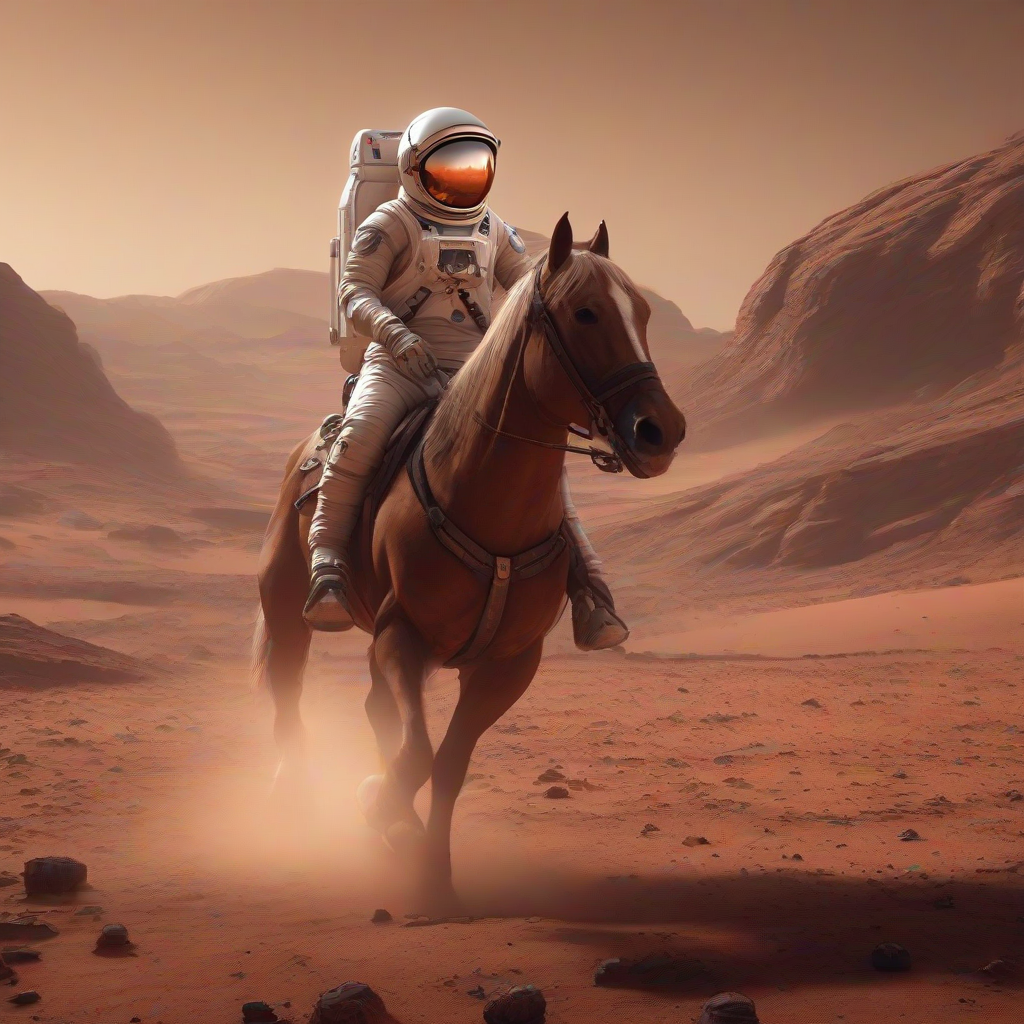

In [ ]:
generator = torch.Generator().manual_seed(seed)

t1 = time.time()
image_fr_and_sm = pipe(prompt, generator=generator, num_inference_steps=num_steps).images[0]
t2 = time.time()

time_fr_and_sm = t2 - t1
print(f"Feature Reuse + Score Mixing Time : {time_fr_and_sm:.2f} seconds")
image_fr_and_sm

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_ddim)
axes[0].axis('off')
axes[0].set_title(f"DDIM\nTime: {time_ddim:.2f} seconds")

axes[1].imshow(image_fr)
axes[1].axis('off')
axes[1].set_title(f"FRDiff\nTime: {time_fr:.2f} seconds")

axes[2].imshow(image_fr_and_sm)
axes[2].axis('off')
axes[2].set_title(f"FR+SM\nTime: {time_fr_and_sm:.2f} seconds")


plt.tight_layout()
plt.show()

SM을 적용한 경우, 생성시간이 더욱 빨라지면서도,  원본 이미지와 형태적 특성이 어느정도 align되는, low frequency 성분이 보존되어 최종 생성 품질이 더 좋은 특성을 보임을 알 수 있습니다. 